In [7]:
import numpy as np

In [ ]:

import pandas as pd

address = "/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.parquet"

df = pd.read_parquet(address)

mb = 1_000_000
df.memory_usage(deep=True).sum() / mb

from pathlib import Path

Path(address).stat().st_size / mb

df.groupby ('VendorID')['trip_distance'].median()


df.columns

columns = ['VendorID', 'trip_distance']
df = pd.read_parquet(address, columns=columns)
df.memory_usage(deep=True).sum() / mb

df.groupby ('VendorID')['trip_distance'].median()

VendorID
1    1.60
2    1.74
Name: trip_distance, dtype: float64

# Type

In [3]:
file_name = '/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.parquet'
df = pd.read_parquet(file_name)

In [4]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
df['total_amount'].describe()

count    1.358017e+06
mean     1.743016e+01
std      1.455326e+01
min     -6.348000e+02
25%      1.100000e+01
50%      1.415000e+01
75%      1.930000e+01
max      6.969300e+03
Name: total_amount, dtype: float64

In [8]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [13]:
# currenct memory usage
mb = 1_000_000 # megabyte
df['total_amount'].memory_usage(deep=True) / mb

21.728272

Current memory usage is 21 megabyte 

In [14]:
# convert columnt to float32
amount = df['total_amount'].astype(np.float32)
amount.memory_usage(deep=True) / mb

16.296204

Current memory usage is 16 megabyte 

# Categorical Data

In [26]:
# Convert to Name
names = {
    1: 'Creative', 
    2: 'veriFone'
}

df['vendor'] = df['VendorID'].map(names)

In [20]:
mb = 1_000_000 # 
id_size = df['VendorID'].memory_usage(deep=True) / mb
name_size = df['vendor'].memory_usage(deep=True) / mb
print (f'id size: {id_size}, name size: {name_size}')

id size: 21.728272, name size: 88.271105


In [23]:
# Convert to categorical 
df['vendor'] = df['vendor'].astype('category')
name_size = df['vendor'].memory_usage(deep=True) / mb
print (name_size)

12.222375


In [28]:
# categorical

df['vendor'][:10]

0    Creative
1    Creative
2    Creative
3    veriFone
4    veriFone
5    veriFone
6    Creative
7    veriFone
8    Creative
9    Creative
Name: vendor, dtype: object

see data as string

In [29]:
# Filter

len (df[df['vendor'] == 'veriFone'])

932127

# Arrow 

In [31]:
# Arrow backend
df = pd.read_parquet(file_name, dtype_backend='pyarrow')

df.memory_usage(deep=True).sum() / mb

216.519175

In [32]:
names = {
    1: 'Creative', 
    2: 'veriFone'
}


df['vendor'] = df['VendorID'].map(names)
df['vendor'].memory_usage(deep=True) / mb

88.440858

In [33]:
# arrow string

df['vendor'] = df['vendor'].astype('string[pyarrow]')
df['vendor'].memory_usage(deep=True) / mb

32.762161

# Iterative computation

In [36]:
# Calculate the average total amount
import pyarrow.parquet as pq

file_name = '/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.parquet'
total, count = 0, 0
for batch in pq.ParquetFile(file_name).iter_batches(batch_size=10_000): # only 10,000 rows at the time will load to memory
    total += batch['total_amount'].sum().as_py()
    count += len(batch)
    
print ('average total_amount:', total / count)
    

average total_amount: 17.430162899286227


# SQL

In [37]:
import sqlite3
import pandas as pd

In [40]:
db_file = '/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.db'
query_sql = '''
SELECT VendorID, SUM(total_amount) AS revenue
From rides
GROUP BY VendorID
'''

# connectiing with sql
conn = sqlite3.connect(db_file)
df = pd.read_sql(query_sql, conn)

df

,VendorID,revenue
0,1,1416915.82
1,2,3317375.83


# calculate faster

<Axes: >

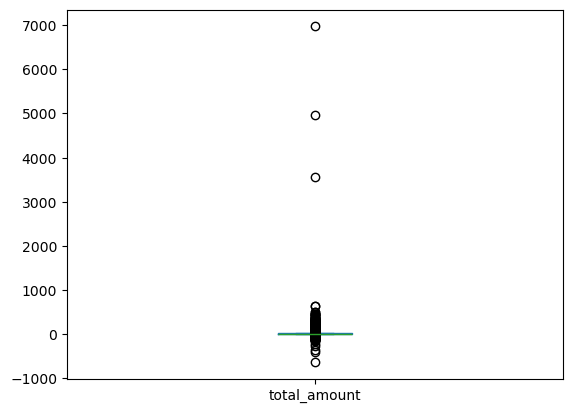

In [43]:
file_name = '/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.parquet'
df = pd.read_parquet(file_name)
df['total_amount'].plot.box()

### Normalise values

In [47]:
# calculate the median
total_med = df['total_amount'].median()
total_med

14.15

In [49]:
# normalize the total
def norm_total (value):
    if value <= 0 or value > 1000:
        return total_med
    return value

In [50]:
# measure how much time it takes to do this
%timeit df['total_amount'].apply(norm_total)

1.06 s ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
# using numba 
import numba

@numba.vectorize # decorator
def norm_total_numba (value):
    if value <= 0 or value > 1000:
        return total_med
    return value

In [53]:
df = pd.read_parquet (file_name)

In [54]:
%%timeit
values = df['total_amount'].to_numpy()
norm_total_numba(values)

9.63 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


in pervious measure 1.06 second but with numba 9.06 ms which is faster

In [57]:
"""
For each VendorID, what is the maximal number of passengers in a ride?
Load at most 10,000 rows to memory.
"""

# %%
import pyarrow.parquet as pq

file_name = '/home/micheal/Documents/GitHub/Streamlit_Resume/MY_RESUME/using-large-datasets-with-pandas-4467955/data/yellow_tripdata_2021-02.parquet'
counts = {}  # VendorID -> count
columns = ['VendorID', 'passenger_count']
for batch in pq.ParquetFile(file_name).iter_batches(batch_size=10_000, columns=columns):
    for i in range(len(batch)):
        vid = batch['VendorID'][i]
        count = batch['passenger_count'][i].as_py()

        if count is None:
            continue

        count = int(count)
        if count > counts.get(vid, 0):
            counts[vid] = count

for vid, count in counts.items():
    print(f'{vid} -> {count}')


1 -> 6
2 -> 9


# Dask

In [58]:
import dask.dataframe as ddf

df = ddf.read_parquet (file_name)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=1,,,,,,,,,,,,,,,,,,,
,int64,datetime64[us],datetime64[us],float64,float64,float64,string,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [64]:
# Maximal tip in percentage where payment is in cash
cash = df[df['payment_type'] == 2] # filter
tip_pct = cash['tip_amount'] / cash['total_amount']
max_tip = tip_pct.max()
max_tip.compute()


0.16666666666666669